In [1]:
import random
import operator
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
def create_cities(n_cities):
    cities = []
    points = []
    for i in range(n_cities):
        x = random.uniform(0, 1000)
        y = random.uniform(0, 1000)
        cities.append(dict(index=i+1, x=x, y=y))
        points.append((x,y))
    points.append(points[0])
    return cities,points

In [3]:
class Graph(object):
    def __init__(self, cost_matrix: list, rank: int):
        self.matrix = cost_matrix
        self.rank = rank
        self.pheromone = (1/(rank*rank)) * np.ones((rank,rank))

In [4]:
def distance(city1: dict, city2: dict):
    return math.sqrt((city1['x'] - city2['x']) ** 2 + (city1['y'] - city2['y']) ** 2)

In [5]:
def plot_cities(points, path: list,showPath = True):
    x = []
    y = []
    for point in points:
        x.append(point[0])
        y.append(point[1])
    y = list(map(operator.sub, [max(y) for i in range(len(points))], y))
    plt.plot(x, y, 'co')
    if showPath:
        for _ in range(1, len(path)):
            i = path[_ - 1]
            j = path[_]
            plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='r', length_includes_head=True)
            plt.text(x[i]+1,y[i]+1,f"{i+1}")
            
    plt.xlim(0, max(x) * 1.1)
    plt.ylim(0, max(y) * 1.1)
    plt.show()

In [6]:
class ACO(object):
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int,
                 strategy: int):
        self.Q = q
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = strategy

    def _update_pheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= self.rho
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_delta[i][j]


    def solve(self, graph: Graph):
        """
        :param graph:
        """
        best_cost = float('inf')
        best_solution = []
        best_each_generation = []
        for gen in range(self.generations):
            ants = [_Ant(self, graph) for i in range(self.ant_count)]
            for ant in ants:
                for i in range(graph.rank - 1):
                    ant._select_next()
                ant.total_cost += graph.matrix[ant.tabu[-1]][ant.tabu[0]]
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.tabu
                # update pheromone
                ant._update_pheromone_delta()
            self._update_pheromone(graph, ants)
            best_each_generation.append(best_cost)
            # print('generation #{}, best cost: {}, path: {}'.format(gen, best_cost, best_solution))
        best_solution.append(best_solution[0])
        return best_solution, best_cost,best_each_generation

In [7]:
class _Ant(object):
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.tabu = []
        self.pheromone_delta = []  
        self.allowed = [i for i in range(graph.rank)] 
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] for i in
                    range(graph.rank)]  
        start = random.randint(0, graph.rank - 1)
        self.tabu.append(start)
        self.current = start
        self.allowed.remove(start)

    def _select_next(self):
        denominator = 0
        for i in self.allowed:
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][ i] ** self.colony.beta
                
        # probabilities for moving to a node in the next step
        probabilities = np.zeros(self.graph.rank)
        for i in range(self.graph.rank):
            try:
                # test if allowed list contains i
                self.allowed.index(i)
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * \
                    self.eta[self.current][i] ** self.colony.beta / denominator
            except ValueError:
                pass
        
        # select next node by probability roulette
        selected = 0
        rand = random.random()
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.allowed.remove(selected)
        self.tabu.append(selected)
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected
        
    def _update_pheromone_delta(self):
        self.pheromone_delta = np.zeros((self.graph.rank,self.graph.rank))
        t = np.array(self.tabu)
        i = t[:-1]
        j = t[1:]
        if self.colony.update_strategy == 1:  # ant-quality system
            self.pheromone_delta[i,j] = self.colony.Q
        elif self.colony.update_strategy == 2:  # ant-density system
            self.pheromone_delta[i,j] = self.colony.Q / self.graph.matrix[i][j]
        else:  # ant-cycle system
            self.pheromone_delta[i,j] = self.colony.Q / self.total_cost

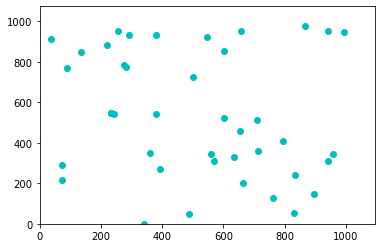

cost: 5593.576773366161, path: [35, 24, 6, 26, 25, 21, 37, 20, 22, 36, 10, 13, 23, 12, 38, 1, 19, 3, 18, 27, 33, 2, 5, 7, 34, 11, 39, 0, 28, 31, 14, 9, 17, 15, 30, 16, 8, 4, 32, 29, 35]


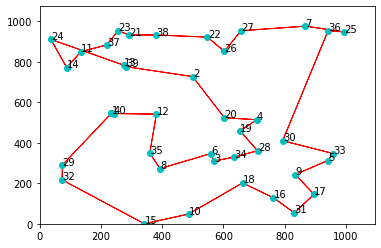

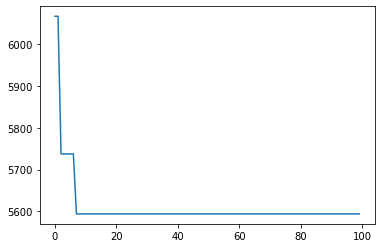

In [9]:
def main():
    
    cities,points = create_cities(40)
    plot_cities(points,[],False)
    cost_matrix = []
    rank = len(cities)
    
    for i in range(rank):
        row = []
        for j in range(rank):
            row.append(distance(cities[i], cities[j]))
        cost_matrix.append(row)
    
    aco = ACO(10, 100, 1.0, 10.0, 0.5, 10, 1)
    graph = Graph(cost_matrix, rank)
    path, cost,best_each_generation = aco.solve(graph)
    print('cost: {}, path: {}'.format(cost, path))
    plot_cities(points, path)
    plt.plot(best_each_generation)
main()